# Введение в анализ данных
## НИУ ВШЭ, 2020-2021 учебный год

### Домашнее задание №8

In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, mean_squared_error

## Градиентный бустинг своими руками (2 + 2* баллов)

Реализуйте алгоритм градиентного бустинга для регрессии. Напомним основные формулы.

Обозначим текущую композицию на $N-1$ шаге за $a_{N - 1}(x_i)$. Следующий базовый алгоритм $b_N(x_i)$ обучается на ответах $-\frac{\partial L(y_i, z)}{\partial z}\Bigl|_{z = a_{N - 1}(x_i)}$, где $L(y_i, z)$ — значение функции потерь на объекте при правильном ответе $y_i$ и предсказании $z$. Композиция на следующем шаге получается следующим образом:

$$
a_N(x_i) = a_{N-1}(x_i) + \nu\gamma_Nb_N(x_i)
$$

Здесь $\nu$ — гиперпараметр learning rate, $\gamma_N$ — оптимальный вес, настраиваемый на каждом шаге алгоритма, который можно найти по следующей формуле (обратите внимание на отсутствие $\nu$):

$$
\gamma_N = \mathrm{arg}\min_\gamma \frac{1}{\ell}\sum\limits_{i=1}^{\ell}L\left(y_i, a_{N - 1}(x_i) + \gamma b_N(x_i)\right)
$$

Можете принять $\gamma_N = 1$ для каждого $N$. Реализуйте нахождение оптимального $\gamma_N$ на каждом шаге, чтобы получить ещё 1 балл.

В качестве функции потерь возьмите MSE.

*Примечание. Вы можете использовать `DecisionTree` из `sklearn` и методы оптимизации из различных библиотек.*

In [314]:
# это может помочь вам для поиска оптимальных gamma
from scipy.optimize import minimize

In [315]:
class GradientBoosting:
    def __init__(self, n_estimators=150, max_depth=3, learning_rate=0.1):
        """
        PARAMETERS:
        n_estimators - number of trees in the ensemble
        max_depth - maximum depth of a tree
        learning_rate - coefficient by which new algorithm result is multiplied
        """
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.learning_rate = learning_rate
        self.estimators = []
        self.gamma = 1
        
    def fit(self, x, y):
        """
        INPUT:
        x - np.array of shape (k, d)
        y - np.array of shape (k,)
        """
        a = np.zeros(y.shape) # Инициализируем ошибку - нули
        for i in range(self.n_estimators):
            y_new = y - a
            b = self._fit_predict_tree(x, y_new)
            a += b

    def _fit_predict_tree(self, x, y):
        # Обучаем дерево и возвращаем его предикшн
        tree = DecisionTreeRegressor(max_depth = self.max_depth)
        tree.fit(x, y)
        self.estimators.append(tree)
        return self.gamma * self.learning_rate * tree.predict(x)
        
    def predict(self, x):
        """
        INPUT:
        x - np.array of shape (m, d)
        OUTPUT:
        y_pred - np.array of shape (m,)
        """
        preds = np.ones(len(x))
        for model in self.estimators:
            new_pred = model.predict(x).reshape(1, -1)
            preds = np.vstack([preds, new_pred])
        preds = preds[1:]
        y_pred = np.sum(preds * self.gamma * self.learning_rate, axis = 0)
        return y_pred
    
    def get_params(self, deep=True):
        return {"n_estimators": self.n_estimators, "max_depth": self.max_depth, "learning_rate": self.learning_rate}
    
    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

In [317]:
# Бустинг с реализованным оптимальным шагом
class GradientBoosting_opt:
    def __init__(self, n_estimators=150, max_depth=3, learning_rate=0.1):
        """
        PARAMETERS:
        n_estimators - number of trees in the ensemble
        max_depth - maximum depth of a tree
        learning_rate - coefficient by which new algorithm result is multiplied
        """
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.learning_rate = learning_rate
        self.estimators = []
        self.gamma = np.ones((self.n_estimators, 1))
        
    def fit(self, x, y):
        """
        INPUT:
        x - np.array of shape (k, d)
        y - np.array of shape (k,)
        """
        # Здесь нам нужно проитерироваться по n_estimators и обучить
        # соответствующее количество деревьев с помощью _fit_predict_tree(),
        # правильно обновляя y_new
        # Деревья нужно где-то сохранить, чтобы затем использовать в predict()
        
        a = np.zeros(y.shape) # Инициализируем ошибку - сначала это нули
        
        for i in range(self.n_estimators):
            y_new = y - a # Задаем таргет - разница 
            b = self._fit_predict_tree(x, y_new) 
            
            def MSE(gamma, y, b, a):
                '''
                Функция, которую удобно запихнуть в scipy.minimize
                '''
                return mean_squared_error(y, gamma * b + a)
            
            self.gamma[i] = minimize(MSE, np.array([0.1]), (y, b, a))['x']
            new_pred = self.gamma[i] * learning_rate * b
            a += new_pred
            

    def _fit_predict_tree(self, x, y):
        # Обучаем дерево и возвращаем его предикшн
        tree = DecisionTreeRegressor(max_depth = self.max_depth)
        tree.fit(x, y)
        self.estimators.append(tree)
        return tree.predict(x)
        
    def predict(self, x):
        """
        INPUT:
        x - np.array of shape (m, d)
        OUTPUT:
        y_pred - np.array of shape (m,)
        """
        # Используем сохранённые деревья для расчёта агрегированного предикшна
        preds = np.ones(len(x))
        for model in self.estimators:
            new_pred = model.predict(x).reshape(1, -1)
            preds = np.vstack([preds, new_pred])
        preds = preds[1:]
        y_pred = np.sum((preds * self.learning_rate) * self.gamma, axis = 0)
        return y_pred
    
    # Последние 2 метода нужны, чтобы на этом эстиматоре работал GridSearch
    def get_params(self, deep=True):
        return {"n_estimators": self.n_estimators, "max_depth": self.max_depth, "learning_rate": self.learning_rate}
    
    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

Проверьте вашу реализацию на Boston dataset. Подберите оптимальные гиперпараметры, чтобы победить RandomForestRegressor как в обычном случае, так и при нахождении оптимального шага **(не меняйте параметры сида)**. При необходимости воспользуйтесь GridSearch. За это вы получите ещё 1 балл.

In [354]:
boston = load_boston()
X = boston.data
y = boston.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=13)

In [355]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(max_features=4, n_estimators=640, random_state=19052019)

rf.fit(X_train, y_train)
mean_squared_error(y_test, rf.predict(X_test))

9.63198271791959

#### Обычный случай без оптимизации веса каждой модели

In [320]:
from sklearn.model_selection import GridSearchCV

Для начала посмотрим, как меняется ошибка на тесте и на трейне, чтобы понять, насколько применим GridSearch в этой конкретной задаче.

In [321]:
import matplotlib.pyplot as plt

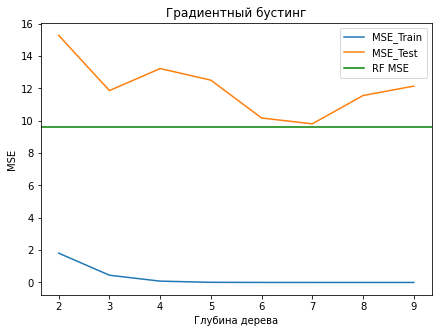

In [357]:
# Визуализация ошибок в зависимости от глубины дерева

plt.figure(figsize=(7,5))

depth = list(range(2, 10))
loss_gb_train = []
loss_gb_test = []
for i in depth:
    np.random.seed(29052019)
    gb = GradientBoosting(n_estimators = 800, learning_rate = 0.03, max_depth = i)
    gb.fit(X_train, y_train)
    loss_gb_train.append(mean_squared_error(y_train, gb.predict(X_train)))
    loss_gb_test.append(mean_squared_error(y_test, gb.predict(X_test)))

plt.plot(depth, loss_gb_train, label = 'MSE_Train')
plt.plot(depth, loss_gb_test, label = 'MSE_Test')
plt.xlabel('Глубина дерева')
plt.ylabel('MSE')
plt.axhline(9.63198271791959, 0, 1, color = 'green', label = 'RF MSE')
plt.title('Градиентный бустинг')
plt.legend();

Очевидно, что ошибка на трейне асимптотически стремится к 0, однако, минимум на тесте приходится на значение "6", что GridSearch не смог бы уловить, т.к. обучается на трейне, поэтому "вылавливать" гиперпараметры будем по графикам, но на GridSearch тоже посмотрим, чтобы показать, что он работает на этом эстиматоре.

**Итак, оптимальный 'max_depth' = 6.**

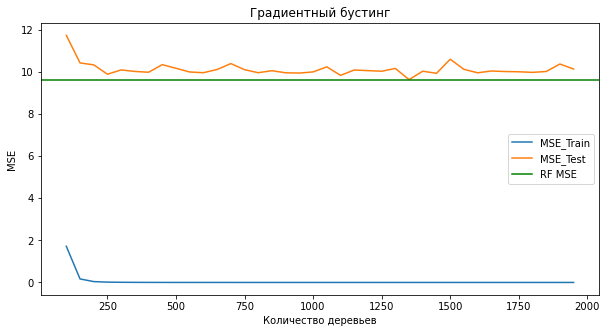

In [360]:
# Визуализация ошибок в зависимостии от количества деревьев
np.random.seed(29052019)
plt.figure(figsize=(10,5))

trees = list(range(100, 2000, 50))
loss_gb_train = []
loss_gb_test = []
for i in trees:
    gb = GradientBoosting(n_estimators = i, learning_rate = 0.03, max_depth = 7)
    gb.fit(X_train, y_train)
    loss_gb_train.append(mean_squared_error(y_train, gb.predict(X_train)))
    loss_gb_test.append(mean_squared_error(y_test, gb.predict(X_test)))

plt.plot(trees, loss_gb_train, label = 'MSE_Train')
plt.plot(trees, loss_gb_test, label = 'MSE_Test')
plt.xlabel('Количество деревьев')
plt.ylabel('MSE')
plt.axhline(9.63198271791959, 0, 1, color = 'green', label = 'RF MSE')
plt.title('Градиентный бустинг')
plt.legend();

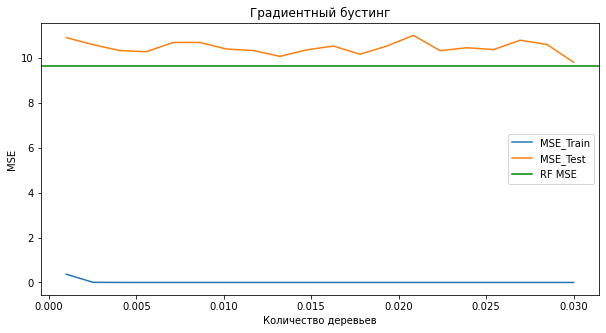

In [338]:
plt.figure(figsize=(10,5))

trees = np.linspace(0.001, 0.03, 20)
loss_gb_train = []
loss_gb_test = []
for i in trees:
    np.random.seed(29052019)
    gb = GradientBoosting(n_estimators = 4000, learning_rate = i, max_depth = 7)
    gb.fit(X_train, y_train)
    loss_gb_train.append(mean_squared_error(y_train, gb.predict(X_train)))
    loss_gb_test.append(mean_squared_error(y_test, gb.predict(X_test)))

plt.plot(trees, loss_gb_train, label = 'MSE_Train')
plt.plot(trees, loss_gb_test, label = 'MSE_Test')
plt.xlabel('Количество деревьев')
plt.ylabel('MSE')
plt.axhline(9.63198271791959, 0, 1, color = 'green', label = 'RF MSE')
plt.title('Градиентный бустинг')
plt.legend();

In [373]:
min_mse_test = np.array(loss_gb_test).min()
print(f"Минимальный MSE на тесте = {min_mse_test}")
print(f"Оптимальное количество деревьев = {trees[np.argmin(np.array(loss_gb_test))]}")

Минимальный MSE на тесте = 9.065785198643878
Оптимальное количество деревьев = 200


Итак, цель достигнута при 

'max_depth' = 6

'n_estimators' = 200

'learning_rate' = 0.2

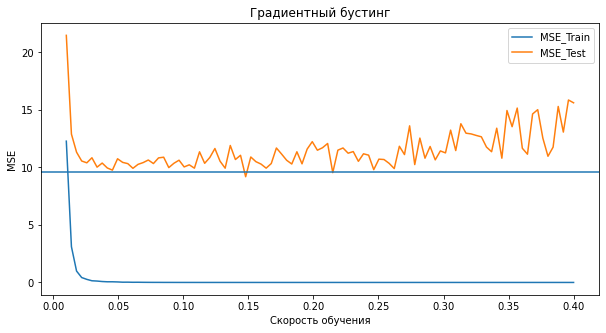

In [374]:
# Визуализация ошибок в зависимости от скорости обучения
np.random.seed(29052019)

plt.figure(figsize=(10,5))

trees = np.linspace(0.01, 0.4, 100)
loss_gb_train = []
loss_gb_test = []
for i in trees:
    gb = GradientBoosting(n_estimators = 200, learning_rate = i, max_depth = 6)
    gb.fit(X_train, y_train)
    loss_gb_train.append(mean_squared_error(y_train, gb.predict(X_train)))
    loss_gb_test.append(mean_squared_error(y_test, gb.predict(X_test)))

plt.plot(trees, loss_gb_train, label = 'MSE_Train')
plt.plot(trees, loss_gb_test, label = 'MSE_Test')
plt.axhline(9.63198271791959, 0, 1, color = 'green', label = 'RF MSE')
plt.xlabel('Скорость обучения')
plt.ylabel('MSE')
plt.title('Градиентный бустинг')
plt.legend();

In [377]:
np.random.seed(29052019)

param_test2 = {
    'max_depth': range(3, 10),
    'learning_rate': [0.01, 0.05, 0.07, 0.1, 0.2],
    'n_estimators':range(150, 600, 50)
}

gsearch2 = GridSearchCV(estimator = GradientBoosting(), 
                       param_grid = param_test2, scoring='neg_mean_squared_error',n_jobs=4,iid=False, cv=5)
gsearch2.fit(X_train,y_train)
gsearch2.best_params_, gsearch2.best_score_

C:\Anaconda\lib\site-packages\sklearn\model_selection\_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


({'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 150},
 -8.326083995693502)

#### Случай с поиском оптимального шага

In [ ]:
np.random.seed(19052019)

Сделаем Аналогично

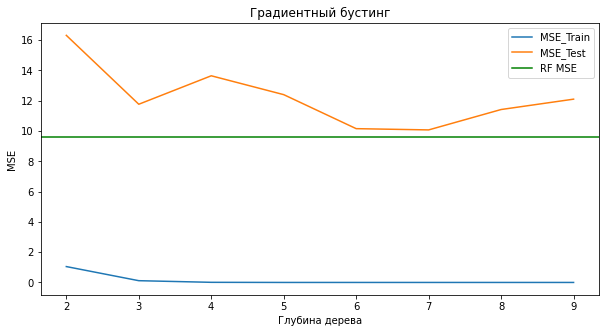

In [382]:
# Визуализация ошибок в зависимости от глубины дерева

plt.figure(figsize=(10,5))

depth = list(range(2, 10))
loss_gbo_train = []
loss_gbo_test = []
for i in depth:
    np.random.seed(29052019)
    gb = GradientBoosting_opt(n_estimators = 400, learning_rate = 0.1, max_depth = i)
    gb.fit(X_train, y_train)
    loss_gbo_train.append(mean_squared_error(y_train, gb.predict(X_train)))
    loss_gbo_test.append(mean_squared_error(y_test, gb.predict(X_test)))

plt.plot(depth, loss_gbo_train, label = 'MSE_Train')
plt.plot(depth, loss_gbo_test, label = 'MSE_Test')
plt.xlabel('Глубина дерева')
plt.ylabel('MSE')
plt.axhline(9.63198271791959, 0, 1, color = 'green', label = 'RF MSE')
plt.title('Градиентный бустинг')
plt.legend();

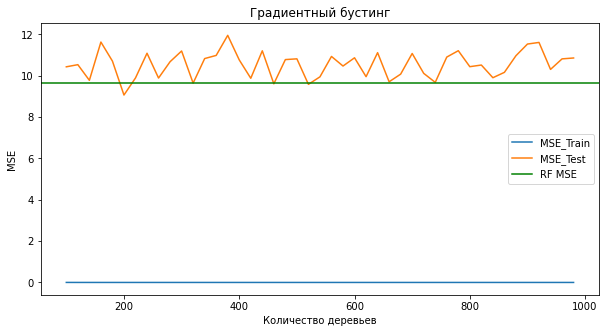

In [384]:
# Визуализация ошибок в зависимостии от количества деревьев
np.random.seed(29052019)
plt.figure(figsize=(10,5))

trees = list(range(100, 1000, 20))
loss_gb_train = []
loss_gb_test = []
for i in trees:
    
    gb = GradientBoosting(n_estimators = i, learning_rate = 0.2, max_depth = 6)
    gb.fit(X_train, y_train)
    loss_gb_train.append(mean_squared_error(y_train, gb.predict(X_train)))
    loss_gb_test.append(mean_squared_error(y_test, gb.predict(X_test)))

plt.plot(trees, loss_gb_train, label = 'MSE_Train')
plt.plot(trees, loss_gb_test, label = 'MSE_Test')
plt.xlabel('Количество деревьев')
plt.ylabel('MSE')
plt.axhline(9.63198271791959, 0, 1, color = 'green', label = 'RF MSE')
plt.title('Градиентный бустинг')
plt.legend();

Получаются точно такие же результаты, Random Forest побежден при

'max_depth' = 6

'n_estimators' = 200

'learning_rate' = 0.2

Для удобства проверяющего укажите, пожалуйста, реализовали ли вы нахождение оптимального шага?

- Да

## Прогнозируем задержки самолётов (2 балла)

Поработаем с задачей про задержки самолётов. На основании доступных данных о рейсе вам нужно определить, будет ли он задержан на 15 минут.
Воспользуйтесь любыми методами градиентного бустинга {XGboost, catboost, LightGBM} и GridSearch для достижения результата. Получите 1 балл за преодоление порога roc_auc_score 0.72 и ещё 1 балл за преодоление порога 0.74.

In [3]:
train = pd.read_csv('https://raw.githubusercontent.com/PersDep/data-mining-intro-2021/main/hw08-boosting-clustering/flight_delays_train.csv')
test = pd.read_csv('https://raw.githubusercontent.com/PersDep/data-mining-intro-2021/main/hw08-boosting-clustering/flight_delays_test.csv')

In [5]:
train.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y


In [6]:
# Референс

from xgboost.sklearn import XGBClassifier

X_train = train[['Distance', 'DepTime']].values
y_train = train['dep_delayed_15min'].map({'Y': 1, 'N': 0}).values
X_test = test[['Distance', 'DepTime']].values
X_train_part, X_valid, y_train_part, y_valid = train_test_split(X_train, y_train, test_size=0.3)

xgb_model = XGBClassifier()
xgb_model.fit(X_train_part, y_train_part)
roc_auc_score(y_valid, xgb_model.predict_proba(X_valid)[:, 1])

C:\Anaconda\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:37:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.7058492886001605

In [9]:
np.set_printoptions(precision=4)
import catboost
from catboost import *
from catboost import datasets

In [10]:
cat_features = list(range(0, X_train.shape[1]))

In [37]:
from catboost import CatBoostClassifier

model = CatBoostClassifier(
    eval_metric='AUC',
    iterations=400,
    random_seed=63,
    learning_rate=0.01
)
model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_valid, y_valid)
)

0:	test: 0.6670650	best: 0.6670650 (0)	total: 69.1ms	remaining: 27.6s
1:	test: 0.7066971	best: 0.7066971 (1)	total: 138ms	remaining: 27.5s
2:	test: 0.7067252	best: 0.7067252 (2)	total: 206ms	remaining: 27.3s
3:	test: 0.7068760	best: 0.7068760 (3)	total: 259ms	remaining: 25.7s
4:	test: 0.7073875	best: 0.7073875 (4)	total: 345ms	remaining: 27.2s
5:	test: 0.7144039	best: 0.7144039 (5)	total: 397ms	remaining: 26.1s
6:	test: 0.7155431	best: 0.7155431 (6)	total: 450ms	remaining: 25.3s
7:	test: 0.7146078	best: 0.7155431 (6)	total: 503ms	remaining: 24.6s
8:	test: 0.7177288	best: 0.7177288 (8)	total: 563ms	remaining: 24.5s
9:	test: 0.7175480	best: 0.7177288 (8)	total: 632ms	remaining: 24.6s
10:	test: 0.7177465	best: 0.7177465 (10)	total: 692ms	remaining: 24.5s
11:	test: 0.7179787	best: 0.7179787 (11)	total: 749ms	remaining: 24.2s
12:	test: 0.7176959	best: 0.7179787 (11)	total: 817ms	remaining: 24.3s
13:	test: 0.7173540	best: 0.7179787 (11)	total: 885ms	remaining: 24.4s
14:	test: 0.7164556	best:

In [38]:
from catboost.utils import get_roc_curve
import sklearn
from sklearn import metrics

eval_pool = Pool(X_valid, y_valid, cat_features=cat_features)
curve = get_roc_curve(model, eval_pool)
(fpr, tpr, thresholds) = curve
roc_auc = sklearn.metrics.auc(fpr, tpr)

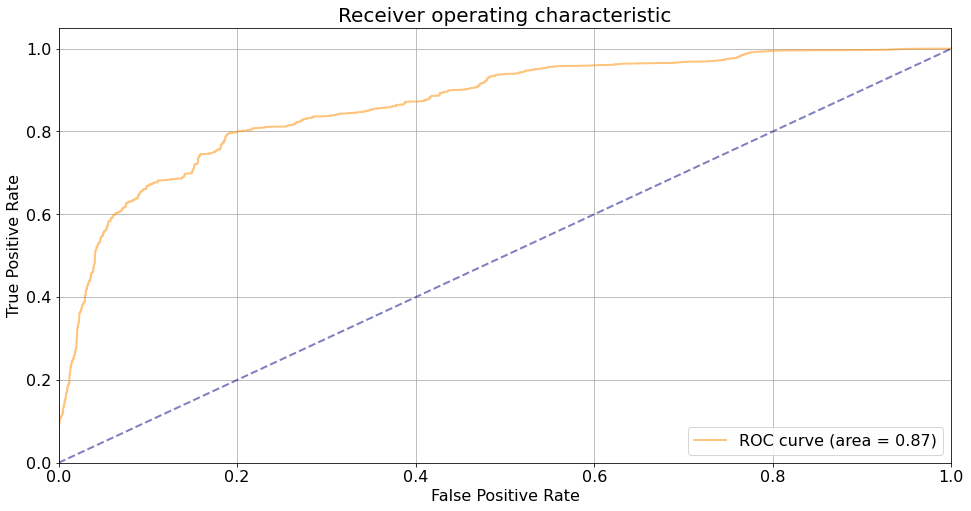

In [39]:
plt.figure(figsize=(16, 8))
lw = 2

plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc, alpha=0.5)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', alpha=0.5)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('Receiver operating characteristic', fontsize=20)
plt.legend(loc="lower right", fontsize=16)
plt.show()

## DBSCAN своими руками (2 + 2* баллов)

DBSCAN: Density-based spatial clustering of applications with noise

Реализуйте класс dbscan.

Алгоритм имеет два основных гиперпараметра:
1. `eps` &mdash; радиус рассматриваемой окрестности
2. `min_samples` &mdash; число соседей в окрестности

Для выполнения кластеризации DBSCAN точки делятся на основные точки, достижимые по плотности точки и выпадающие следующим образом:

- Точка $p$ является основной точкой, если по меньшей мере `min_samples` точек находятся на расстоянии, не превосходящем 
`eps` от неё. Говорят, что эти точки достижимы прямо из $p$.

-  Точка $q$ прямо достижима из $p$, если точка $q$ находится на расстоянии, не большем `eps`, от точки $p$, и $p$ — основная точка.
Точка $q$ достижима из $p$, если имеется путь 
$p_1,…,p_n$ где $p_1=p$ и $p_n=q$ , а каждая точка $p_{i+1}$ достижима прямо из $p_i$ (все точки на пути должны быть основными, за исключением $q$).

Все точки, не достижимые из основных точек, считаются выбросами.

Теперь, если $p$ является основной точкой, то она формирует кластер вместе со всеми точками (основными или неосновными), достижимыми из этой точки. Каждый кластер содержит по меньшей мере одну основную точку. Неосновные точки могут быть частью кластера, но они формируют его «край», поскольку не могут быть использованы для достижения других точек.


In [4]:
# Это может помочь вам для поиска дистанции между точками
from scipy.spatial import distance

In [11]:
'''
Как кодируются категории:
0 - не кластеризованная
-1 - noise
дальше номер кластера
'''

'\n0 - не кластеризованная\nn - noise\nдальше номер кластера\n'

In [349]:
# Рекомендации -- это только рекомендации
class dbscan:
    def __init__(self, eps, min_samples):
        
        self.eps = eps
        self.min_samples = min_samples
        self.cluster_names = [0]
        self.cluster = []
        
    def fit_predict(self, X):
        # Помечаем переданные точки, чтобы отличать уже кластеризованные
        # или являющиеся шумом от остальных
        self.cluster = [0] * len(X)
        # Реализуем цикл по точкам, игнорирущий уже кластеризованные
        for i in range(len(X)):
            if self.cluster[i] == 0 or self.cluster[i] == -1:
                neighbours = self.range_query(X[i], X) # Ищем соседей
                if len(neighbours) < self.min_samples:
                    self.cluster[i] = -1
                else:
                    self.cluster[i] = self.cluster_names[-1] + 1 # Новое имя кластера
                    self.cluster_names.append(self.cluster_names[-1] + 1) # Добавляем новое имя в список имен кластеров          
                    self.grow_cluster(neighbours, X)
        return np.array(self.cluster)
    
    def grow_cluster(self, neighbours, X):
        for point in neighbours:
            if self.cluster[point] == 0 or self.cluster[point] == -1: # Если точка не было посещена до этого
                self.cluster[point] = self.cluster_names[-1] # Присваиваем имя нового кластера
                new_neigh = self.range_query(X[point], X) # Ищем список ее соседей
                if len(new_neigh) >= self.min_samples: # Если она основная
                    neighbours = neighbours.union(new_neigh) # Объединяем множества соседей
                    self.grow_cluster(neighbours, X) # Продолжаем поиск

    def range_query(self, x, X):
        neighbours = np.where(dist(X, x.reshape(1, -1)) <= self.eps)[0]
        return set(neighbours)
    
    @staticmethod
    def dist(a, b):
        return distance.cdist(a, b)

Проверим себя на простом примере:

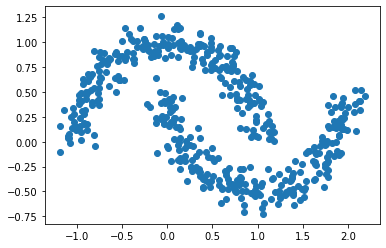

In [350]:
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
import pandas as pd

X, _ = make_moons(n_samples=500, noise=0.1)
plt.scatter(X[:,0], X[:,1])
plt.show()

Кластеризуйте это с помощью своей версии DBSCAN:

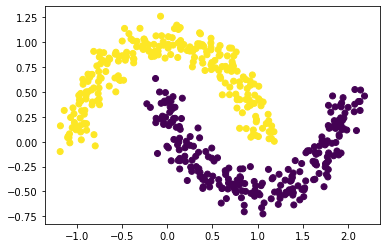

In [351]:
clust = dbscan(eps=0.2, min_samples=10).fit_predict(X)

plt.scatter(X[:,0], X[:,1], c=clust)
plt.show()

Референс:

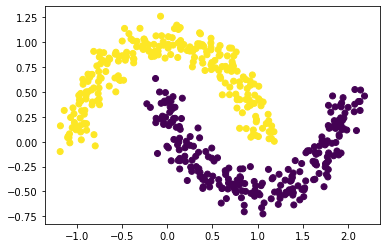

In [353]:
from sklearn.cluster import DBSCAN

clusters = DBSCAN(eps=0.2, min_samples=10).fit_predict(X)

plt.scatter(X[:,0], X[:,1], c=clusters)
plt.show()

Получите 1 балл за ещё один интересный пример кластеризации (в качестве референса используйте предоставленное изображение. Нужно несколько интересных соседствующих форм):

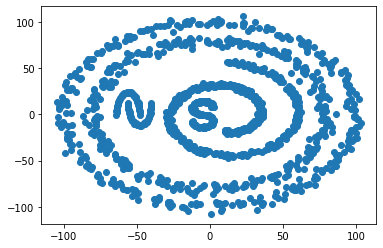

In [ ]:
# your code here

Или хотя бы что-нибудь такое: 

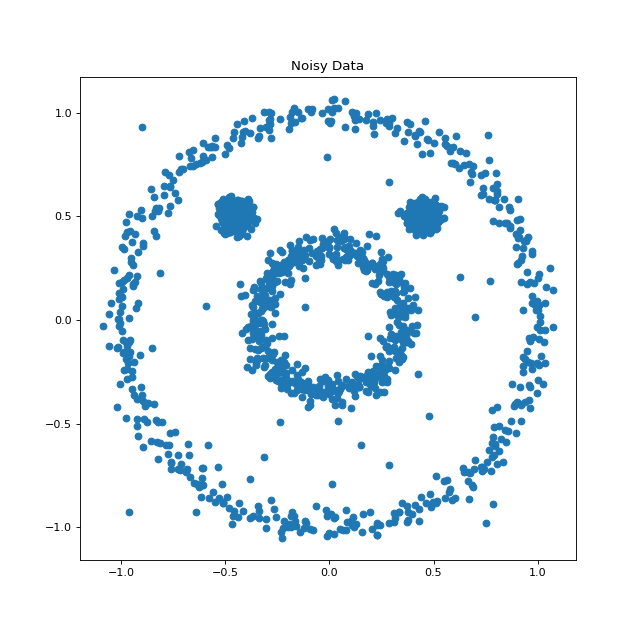

### Так данные выглядят в оригинале

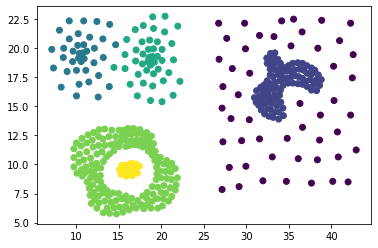

In [281]:
cl = pd.read_csv('clustering.csv', sep=';')
cl.head()
plt.scatter(cl['0'],cl['1'], c=cl['2'])
plt.show()

### Так их разбивает мой dbscan и, кажется, это лучшее, что можно с этим сделать

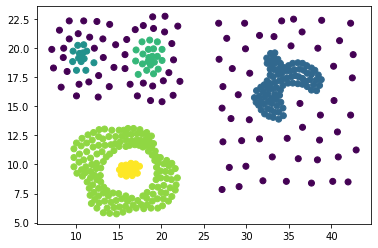

In [304]:
X = cl[['0', '1']].to_numpy()
y = cl['2']

clust_ = dbscan(eps=1.45, min_samples=13).fit_predict(X)

plt.scatter(cl['0'],cl['1'], c=clust_)
plt.show()

Получите ещё 1 балл, если время работы вашего алгоритма больше референсного не более чем в 100 раз с учётом погрешности 3% от вашего времени:

In [310]:
# Проверка на прошлых данных

In [311]:
X, _ = make_moons(n_samples=500, noise=0.1)

In [312]:
%%time
%%capture
clusters = DBSCAN(eps=0.2, min_samples=10).fit_predict(X)

Wall time: 4.99 ms


In [313]:
%%time
%%capture
clusters = dbscan(eps=0.2, min_samples=10).fit_predict(X)

Wall time: 54.9 ms
